In [19]:
import torch
import numpy as np

from models.cnp import CNP

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")

In [36]:
def normalize(x, y, vx, vy):  # normalize to [-1, 1]
    x_min, x_max = torch.min(x), torch.max(x)
    y_min, y_max = torch.min(y), torch.max(y)
    vx_min, vx_max = torch.min(vx), torch.max(vx)
    vy_min, vy_max = torch.min(vy), torch.max(vy)
    x = 2*(x - x_min)/(x_max - x_min) - 1
    y = 2*(y - y_min)/(y_max - y_min) - 1
    vx = 2*(vx - vx_min)/(vx_max - vx_min) - 1
    vy = 2*(vy - vy_min)/(vy_max - vy_min) - 1
    return x, y, vx, vy

In [37]:
nof_demonstrations = 32
nof_timesteps = 200

x = torch.from_numpy(np.load('/home/yigit/projects/mbcnp/data/raw/dataverse_files/Sines_full/constrained_torques.npy'))[:nof_demonstrations, :nof_timesteps]
y = torch.from_numpy(np.load('/home/yigit/projects/mbcnp/data/raw/dataverse_files/Sines_full/measured_angles.npy'))[:nof_demonstrations, :nof_timesteps]

vx = torch.from_numpy(np.load('/home/yigit/projects/mbcnp/data/raw/dataverse_files/Sines_full/constrained_torques.npy'))[nof_demonstrations, :nof_timesteps].unsqueeze(0)
vy = torch.from_numpy(np.load('/home/yigit/projects/mbcnp/data/raw/dataverse_files/Sines_full/measured_angles.npy'))[nof_demonstrations, :nof_timesteps].unsqueeze(0)

x, y, vx, vy = normalize(x, y, vx, vy)

print('training:', x.shape, y.shape)
print('validation:', vx.shape, vy.shape)

training: torch.Size([32, 200, 3]) torch.Size([32, 200, 3])
validation: torch.Size([1, 200, 3]) torch.Size([1, 200, 3])


In [38]:
batch_size = 16

model = CNP(3, 512, 3, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [39]:
def get_batch(x, y, traj_ids):
    dx, dy = x.shape[-1], y.shape[-1]
    n = x.shape[1]
    n_t = torch.randint(1, model.n_max_tar, (1,)).item()
    n_o = torch.randint(1, model.n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(n)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        # print(x.shape, traj_ids[i], o_ids, t_ids)

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

In [40]:
epochs = 500_000 #1_000_000
epoch_iter = 2
min_loss = 1_000_000
avg_loss = 0

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, encoded_rep = model(obs, tar_x)
        loss = model.loss(pred, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch_loss < min_loss and epoch > 5e4:
        min_loss = epoch_loss
        torch.save(model.state_dict(), f'best_test_on_rrd.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
        avg_loss = 0

Epoch: 0, Loss: 0.014851885437965394
Epoch: 100, Loss: -0.6244687069486826
Epoch: 200, Loss: -1.683798339366913
Epoch: 300, Loss: -2.0204099261760713
Epoch: 400, Loss: -2.1767496556043624
Epoch: 500, Loss: -2.3267056441307066
Epoch: 600, Loss: -2.529358848333359
Epoch: 700, Loss: -2.6214960277080537
Epoch: 800, Loss: -2.756529110074043
Epoch: 900, Loss: -2.8736476039886476
Epoch: 1000, Loss: -2.895778626203537
Epoch: 1100, Loss: -3.050925263762474
Epoch: 1200, Loss: -3.0522393667697907
Epoch: 1300, Loss: -3.1415253251791
Epoch: 1400, Loss: -3.2406327891349793
Epoch: 1500, Loss: -3.196955666542053
Epoch: 1600, Loss: -3.3199597811698913
Epoch: 1700, Loss: -3.3612715125083925
Epoch: 1800, Loss: -3.3721978068351746
Epoch: 1900, Loss: -3.367648563981056
Epoch: 2000, Loss: -3.464805508852005
Epoch: 2100, Loss: -3.4566765183210375
Epoch: 2200, Loss: -3.552367273569107
Epoch: 2300, Loss: -3.5863076138496397
Epoch: 2400, Loss: -3.6124784404039385
Epoch: 2500, Loss: -3.687008498907089
Epoch: 260

KeyboardInterrupt: 

In [41]:
t_or_r = True  # test on traj or get latent representations

model = CNP(3, 512, 3, batch_size=batch_size).to(device)
model.load_state_dict(torch.load('best_test_on_rrd.pt'))
model.eval()
if t_or_r:
    traj_id = torch.randint(0, vx.shape[0], (1,)).item()
    
    obs_points = [0, 10, 100, -1]
    o = torch.cat((vx[traj_id, obs_points], vy[traj_id, obs_points]), dim=-1).float().unsqueeze(0).to(device)
    t = vx[traj_id, :].float().unsqueeze(0).to(device)
    print(o.shape, t.shape)

    with torch.no_grad():
        traj, _ = model(o, t)
    print(traj.shape)
else:
    batch_size = 50
    o, t, tr = get_batch(x, y, torch.arange(batch_size))

    with torch.no_grad():
        _, r = model(o, t)

    print(r.shape)

torch.Size([1, 4, 6]) torch.Size([1, 200, 3])
torch.Size([1, 200, 6])


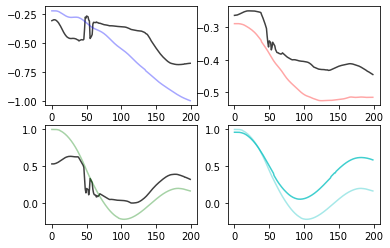

In [42]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

if t_or_r:
    trj = traj.cpu().numpy()

    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(trj[0, :, 0], c='k', alpha=0.75)
    axs[0, 0].plot(vy[traj_id, :, 0], c='b', alpha=0.35)
    axs[0, 1].plot(trj[0, :, 1], c='k', alpha=0.75)
    axs[0, 1].plot(vy[traj_id, :, 1], c='r', alpha=0.35)
    axs[1, 0].plot(trj[0, :, 2], c='k', alpha=0.75)
    axs[1, 0].plot(vy[traj_id, :, 2], c='g', alpha=0.35)
    axs[1, 1].plot(y[-1, :, 2], c='c', alpha=0.75)
    axs[1, 1].plot(vy[traj_id, :, 2], c='c', alpha=0.35)
else:
    colors = ["b", "r", "g", "y"]

    latent_values = r.squeeze(1).cpu().numpy()
    kmeans = KMeans(n_clusters=4, random_state=0)
    labels = kmeans.fit_predict(latent_values)

    print(np.mean(labels), labels, sep='\n')
    pca = PCA(n_components=2)
    reduced_latent = pca.fit_transform(latent_values)

    label_colors = []
    for i in labels:
        label_colors.append(colors[i])
    plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=label_colors, s=30)